In [ ]:
#MODELO DE CLASSIFICAÇÃO - MODELO PREDITIVO DE SELEÇÃO DA META-HEURÍSTICA ----------------------------------------------------------------------------

import pandas as pd
import os
import random
import math
import numpy as np 
from matplotlib import pyplot as plt
import xlwings as xw
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize


#EXCEL - CAMINHO DO FICHEIRO
file_path = r"D:\Documentos\...\DataSet_ModeloClassificação.xlsx"
dados_problema= pd.read_excel(file_path)
print (dados_problema)
#print(dados_problema['MH'].value_counts())

       MH  NJOBS  NMACHINES  CMAXOPT OBJFUNC  CMAX
0      SA      6          6       55    Cmax    59
1     PSO      6          6       55    Cmax    59
2     PSO      6          6       55    Cmax    59
3     PSO      6          6       55    Cmax    60
4      SA      6          6       55    Cmax    60
...   ...    ...        ...      ...     ...   ...
1003   GA     50         10     3104      WT  5600
1004   GA     50         10     3104    Cmax  5602
1005   GA     50         10     3104    Cmax  5617
1006   GA     50         10     3104    Cmax  5628
1007   GA     50         10     3104      WT  5661

[1008 rows x 6 columns]


In [7]:
#DIVIDIR DADOS EM TREINO E TESTE -------------------------------------------------------------------------------------------------------
#RETIRAR COLONA CMAX (NÃO É UMA FEATURE)
dados_problema=dados_problema.drop(columns=['CMAX'])
#print (dados_problema)

#VARIÁVEIS DEPENDENTES E INDEPENDENTES
X = dados_problema.drop(columns=['MH'])
y = dados_problema['MH']

#COLUNA OBJFUNX: PASSAR CMAX = 0 E WT=1 (NECESSÁRIO PARA ALGUMAS TÉCNICAS DE MACHINE LEARNING)
X['OBJFUNC'] = X['OBJFUNC'].map({'Cmax': 0, 'WT': 1})

#DIVIDIR COM ESTRATIFICAÇÃO (MH)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#VERIFICAR A DISTRIBUIÇÃO APÓS A DIVISÃO 
print (y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

SA     0.358865
TS     0.324823
PSO    0.243972
GA     0.072340
Name: MH, dtype: float64 SA     0.359736
TS     0.323432
PSO    0.244224
GA     0.072607
Name: MH, dtype: float64


Fitting 10 folds for each of 648 candidates, totalling 6480 fits

Melhores parâmetros:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor pontuação (f1_weighted): 0.5894

Resultados no conjunto de teste:
Acurácia: 0.6634
F1-score: 0.6665
Precision: 0.6949
Recall: 0.6634
AUC (média One-vs-Rest): 0.8847


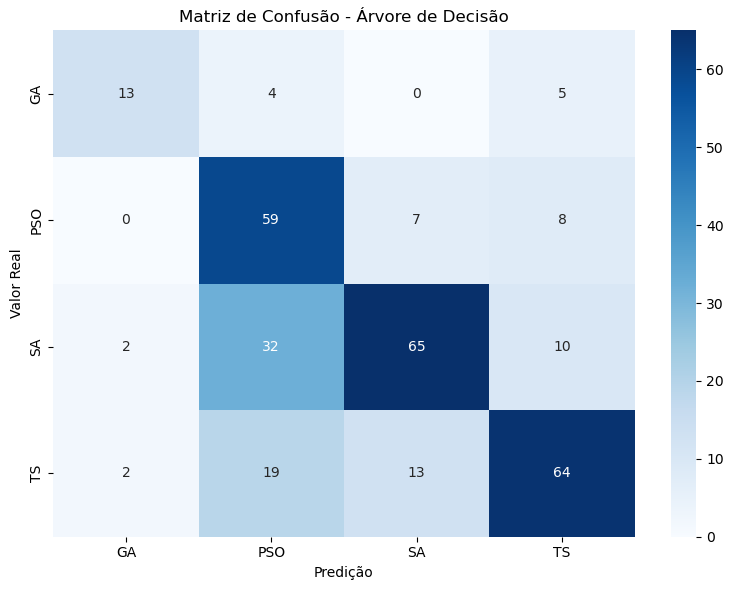

In [ ]:
#ÁRVORE DE DECISÃO -----------------------------------------------------------------------------------------------------------------------------------

#DEFINIÇÃO DOS PARAMETROS 
parametros = {
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth': [None, 3, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],   
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 10, 15]       
}

#CRIAÇÃO DA ÁRVORE
arvore = DecisionTreeClassifier(random_state=42)

#CONFIGURAÇÃO DOS HIPERPARÂMETROS COM VALIDAÇÃO CRUZADA 
grid_search = GridSearchCV(
    estimator=arvore,
    param_grid=parametros,
    cv=10,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

#TREINAR O MODELO À PROCURA DOS MLEHORES HIPERPARÂMETROS 
grid_search.fit(X_train, y_train)
print("\nMelhores parâmetros:")
print(grid_search.best_params_)
print(f"Melhor pontuação (f1_weighted): {grid_search.best_score_:.4f}")

#OBTER O MELHOR MODELO
melhor_modelo_AD = grid_search.best_estimator_

#AVALIAR O MODELO NOS DADOS DE TESTE
y_pred = melhor_modelo_AD.predict(X_test)

#OBTER PROBABILIDADES PARA O CÁLCULO DO AUC 
y_prob = melhor_modelo_AD.predict_proba(X_test)

#CALCULAR AS MÉTRICAS DE AVALIAÇÃO
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

#CALCULAR AUC USANDO ONE-VS-REST
classes = melhor_modelo_AD.classes_
y_test_bin = label_binarize(y_test, classes=classes)

#CALCULAR AUC PARA CADA CLASSE
auc_scores = []
for i in range(len(classes)):
    if i < len(y_prob[0]):  
        auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob[:, i]))
mean_auc = np.mean(auc_scores)          #MÉDIA DAS CLASSES

print("\nResultados no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC (média One-vs-Rest): {mean_auc:.4f}")

#CRIAR A MATRIZ DE CONFUSÃO
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Árvore de Decisão')
plt.tight_layout()
plt.show()

Fitting 10 folds for each of 1200 candidates, totalling 12000 fits

Melhores parâmetros:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Melhor pontuação F1 na validação cruzada: 0.5905

Resultados no conjunto de teste:
Acurácia: 0.6700
F1-score: 0.6697
Precision: 0.6792
Recall: 0.6700
AUC (média One-vs-Rest): 0.8803


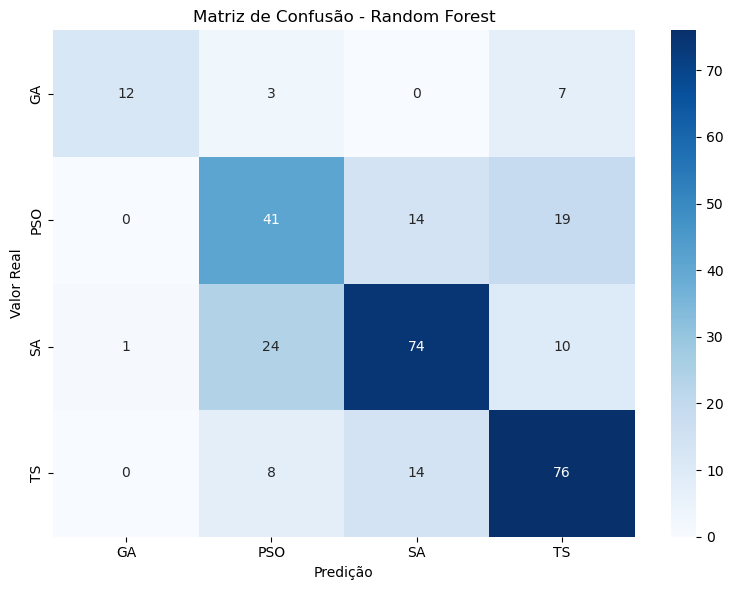

In [ ]:
#RANDOM FOREST -----------------------------------------------------------------------------------------------------------------------------------

#DEFINIÇÃO DOS PARÂMETROS
parametros = {
    'n_estimators': [50, 100, 200, 300, 400],            
    'max_depth': [None, 5, 10, 20, 30],           
    'min_samples_split': [ 2, 5, 10, 15],            
    'min_samples_leaf': [1, 2, 4, 6],              
    'max_features': ['sqrt', 'log2', None]      
}

#CRIAR RANDOM FOREST 
rf = RandomForestClassifier(random_state=42)

#CONFIGURAÇÃO DOS HIPERPRÂMETROS COM VALIDAÇÃO CRUZADA
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=parametros,
    cv=10,                      
    scoring='f1_weighted',     
    n_jobs=-1,                 
    verbose=2                  
)

#TREINAR O MODELO À PROCURA DOS MELHORES HIPERPARÂMETROS 
grid_search.fit(X_train, y_train)

#MELHORES PARÂMETROS
print("\nMelhores parâmetros:")
print(grid_search.best_params_)
print(f"Melhor pontuação F1 na validação cruzada: {grid_search.best_score_:.4f}")

#OBTER O MELHOR MODELO
melhor_modelo_RF = grid_search.best_estimator_

#AVALIAR CONJUNTO TESTE
y_pred = melhor_modelo_RF.predict(X_test)

#OBTER PROBABILIDADES PARA O CÁLCULO DO AUC 
y_prob = melhor_modelo_RF.predict_proba(X_test)

#CALCULAR AS MÉTRICAS DE AVALIAÇÃO
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

#CALCULAR AUC USANDO ONE-VS-REST
classes = melhor_modelo_RF.classes_
y_test_bin = label_binarize(y_test, classes=classes)

#CALCULAR AUC PARA CADA CLASSE
auc_scores = []
for i in range(len(classes)):
    if i < len(y_prob[0]):  
        auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob[:, i]))
mean_auc = np.mean(auc_scores)      #MÉDIA DAS CLASSES

print("\nResultados no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC (média One-vs-Rest): {mean_auc:.4f}")

#MATRIZ DE CONFUSÃO
class_names = ['GA', 'PSO', 'SA', 'TS']
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Random Forest')
plt.tight_layout()
plt.show()


Fitting 10 folds for each of 80 candidates, totalling 800 fits
Melhores parâmetros:
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Melhor pontuação de validação cruzada: 0.4944

Resustados no conjunto de teste:
Acurácia: 0.5446
F1 Score: 0.5432
Precision: 0.5636
Recall: 0.5446
AUC (média One-vs-Rest): 0.5000


c:\Users\Ana Silva\Anaconda\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


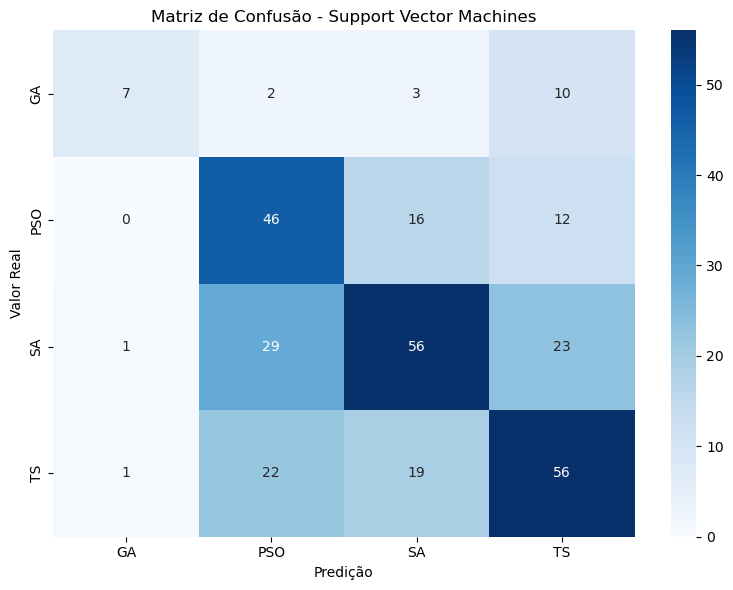

In [10]:
#SUPPORT VECTOR MACHINES --------------------------------------------------------------------------------------------------------------------------------

#PADRONIZAÇÃO DOS DADOS (IMPORTANTE PARA SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#DEFINIÇÃO PARÂMETROS
param_grid = {
    'C': [0.1, 1, 10, 100, 1000], #[0.01, 0.1, 1, 10, 100, 1000]
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

#CRIAR SUPPORT VECTO MACHINES 
svm = SVC(random_state=42, probability=True)

#CONFIGURAÇÃO HIPERPARAMETROS COM VALIDAÇÃO CRUZADA
grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=10,
    scoring='f1_weighted',  
    verbose=1,
    n_jobs=-1  
)

#TREINAR O MODELO À PROCURA DOS MELHORE HIPERPARÂMETROS
grid_search.fit(X_train_scaled, y_train)

#MELHORES PARÂMETROS 
print("Melhores parâmetros:")
print(grid_search.best_params_)
print(f"Melhor pontuação de validação cruzada: {grid_search.best_score_:.4f}")

#OBTER O MELHOR MODELO
best_svm = grid_search.best_estimator_

#AVALIAR CONJUNTO DE TESTE
y_pred = best_svm.predict(X_test_scaled)

#OBTER PROBABILIDADES PARA O CÁLCULO DO AUC 
y_prob = best_svm.predict_proba(X_test)

#CALCULAR AS MÉTRICAS DE AVALIAÇÃO
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

#CALCULAR AUC  USANDO ONE-VS-REST
classes = best_svm.classes_
y_test_bin = label_binarize(y_test, classes=classes)

#CALCULAR AUC PARA CADA CLASSE
auc_scores = []
for i in range(len(classes)):
    if i < len(y_prob[0]):  
        auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob[:, i]))
mean_auc = np.mean(auc_scores)      #MÉDIA DAS CLASSES

print("\nResustados no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC (média One-vs-Rest): {mean_auc:.4f}")

#MATRIZ DE CONFUSÃO
class_names = ['GA', 'PSO', 'SA', 'TS']
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Support Vector Machines')
plt.tight_layout()
plt.show()

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 48 candidates, totalling 480 fits

Melhor modelo: MultinomialNB com pontuação: 0.3334
Parâmetros do melhor modelo (MultinomialNB): {'alpha': 0.01, 'fit_prior': True}

Resultados no conjunto de teste:
Acurácia: 0.3663
F1 Score (weighted): 0.3382
Precision (weighted): 0.3568
Recall (weighted): 0.3663
AUC (média One-vs-Rest): 0.6167


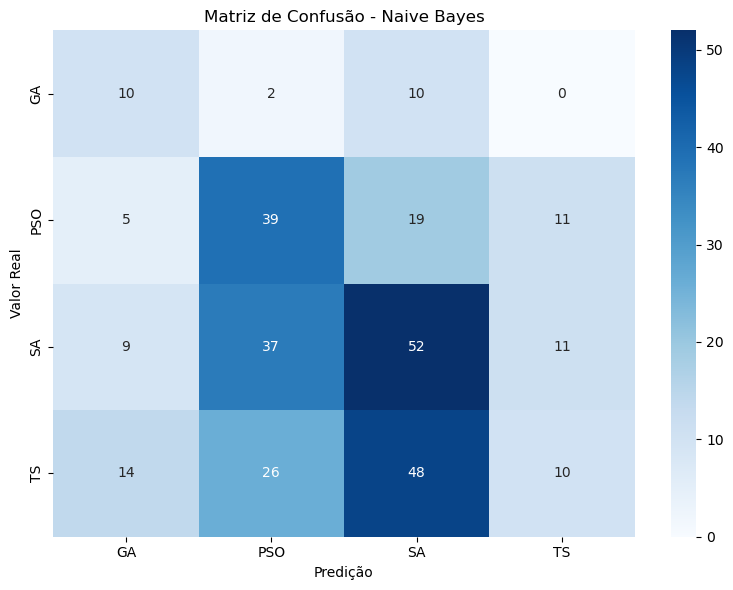

In [11]:
#NAIVE BAYES --------------------------------------------------------------------------------------------------------------------------------

#TESTAR DIFERENTES TIPOS DE MODELOS 

# 1. GAUSSIAN NAIBE BAYES 
params_gnb = {
    'var_smoothing': np.logspace(-10, -1, 10)  
}
gnb = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=params_gnb,
    cv=10,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)
gnb.fit(X_train, y_train)

# 2. MULTIMODAL NAIVE BAYES 
if np.all(X_train >= 0):
    params_mnb = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],  
        'fit_prior': [True, False] 
    }
    mnb = GridSearchCV(
        estimator=MultinomialNB(),
        param_grid=params_mnb,
        cv=10,
        scoring='f1_weighted',
        verbose=1,
        n_jobs=-1
    )
    mnb.fit(X_train, y_train)
    #print("\nMelhor MultinomialNB:")
    #print(mnb.best_params_)
    #print(f"Melhor pontuação (MultinomialNB): {mnb.best_score_:.4f}")

# 3. BERNOULLI NAIVE BAYES 
params_bnb = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'binarize': [0.0, 0.5, 1.0, None],  
    'fit_prior': [True, False]
}
bnb = GridSearchCV(
    estimator=BernoulliNB(),
    param_grid=params_bnb,
    cv=10,
    scoring='f1_weighted',
    verbose=1,
    n_jobs=-1
)
bnb.fit(X_train, y_train)

#COMPARAR OS 3 MODELOS E ESCOLHER O MELHOR 
models = []
if 'gnb' in locals():
    models.append(('GaussianNB', gnb))
if 'mnb' in locals():
    models.append(('MultinomialNB', mnb))
if 'bnb' in locals():
    models.append(('BernoulliNB', bnb))

#ENCONTRAR O MELHOR MODELO
best_model_name = None
best_score = -1
best_model = None
for name, model in models:
    if model.best_score_ > best_score:
        best_score = model.best_score_
        best_model_name = name
        best_model = model.best_estimator_
print(f"\nMelhor modelo: {best_model_name} com pontuação: {best_score:.4f}")
for name, model in models:
    if name == best_model_name:
        print(f"Parâmetros do melhor modelo ({name}): {model.best_params_}")
        break

#AVALIAÇÃO DO MELHOR MODELO NO CONJUNTO TESTE
y_pred = best_model.predict(X_test)

#OBTER PROBABILIDADES PARA O CÁLCULO DO AUC 
y_prob = best_model.predict_proba(X_test)

#CALCULAR MÉTRICAS DE AVALIAÇÃO
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

#CALCULAR AUC ONE-VS-REST
classes = best_model.classes_
y_test_bin = label_binarize(y_test, classes=classes)

#CALCULAR AUC PARA CADA CLASSE
auc_scores = []
for i in range(len(classes)):
    if i < len(y_prob[0]):  
        auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob[:, i]))
mean_auc = np.mean(auc_scores)      #MÉDIA DAS CLASSES

print("\nResultados no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"AUC (média One-vs-Rest): {mean_auc:.4f}")


#MATRIZ DE CONFUSÃO
class_names = ['GA', 'PSO', 'SA', 'TS']
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Naive Bayes')
plt.tight_layout()
plt.show()


Fitting 10 folds for each of 768 candidates, totalling 7680 fits


c:\Users\Ana Silva\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
640 fits failed out of a total of 7680.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ana Silva\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ana Silva\Anaconda\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ana Silva\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1203, in fi

Melhores parâmetros:
{'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Melhor pontuação de validação cruzada: 0.3621

Resultados no conjunto de teste:
Acurácia: 0.3729
F1 Score (weighted): 0.3733
Precision (weighted): 0.4005
Recall (weighted): 0.3729
AUC (média One-vs-Rest): 0.5770


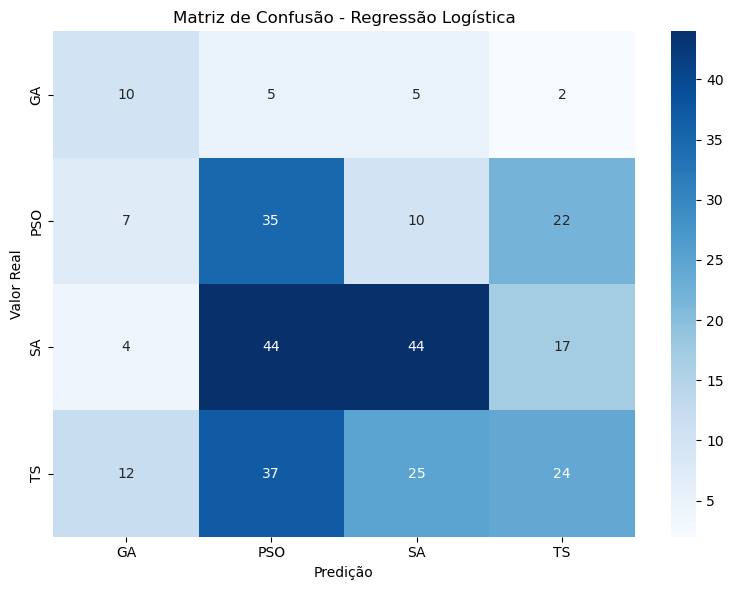

In [12]:
#REGRESSÃO LOGÍSTICA --------------------------------------------------------------------------------------------------------------------------------

#PADRONIZAÇÃO DOS DADOS 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#DEFINIÇÃO PARÂMETROS
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],  
    'penalty': ['l1', 'l2', 'elasticnet', None],  
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'max_iter': [100, 500, 1000, 2000],  
    'class_weight': [None, 'balanced']  #
}

#NEM TODAS AS COMBINAÇÕES DOS PARÂMETROS SÃO VÁLIDAS, POR EXEMPLO, 'liblinear' SÓ SUPORTA PENALIZAÇÕES 'l1' E 'l2'
#EVITAR COMBINAÇÕES INVÁLIDAS
refined_param_grid = [
    # Para solver='liblinear'
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
     'max_iter': [100, 500, 1000, 2000], 'class_weight': [None, 'balanced']},
    
    # Para solver='saga'
    {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
     'max_iter': [100, 500, 1000, 2000], 'class_weight': [None, 'balanced']},
    
    # Para solver='newton-cg', 'lbfgs', 'sag'
    {'solver': ['newton-cg', 'lbfgs', 'sag'], 'penalty': ['l2', None], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 
     'max_iter': [100, 500, 1000, 2000], 'class_weight': [None, 'balanced']}
]

#CONFIGURAÇÃO HIPERPARÂMETROS COM VALIDAÇÃO CRUZADA
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=refined_param_grid,
    cv=10,
    scoring='f1_weighted',  
    verbose=1,
    n_jobs=-1 
)

#TREINAR O MODELO À PROCURA DOS MELHORES HIPERPARÂMETROS
grid_search.fit(X_train_scaled, y_train)

#MELHOR PARÂMETROS 
print("Melhores parâmetros:")
print(grid_search.best_params_)
print(f"Melhor pontuação de validação cruzada: {grid_search.best_score_:.4f}")

#OBTER O MELHOR MODELO
best_logreg = grid_search.best_estimator_

#AVALIAR CONJUNTO DE TESTE
y_pred = best_logreg.predict(X_test_scaled)

#OBTER PROBABILIDADES PARA O CÁLCULO DO AUC 
y_prob = best_logreg.predict_proba(X_test)

#CÁLCULA DAS MÉTRICAS DE AVALIAÇÃO
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

#CALCULAR AUC USANDO ONE-VS-REST
classes = best_logreg.classes_
y_test_bin = label_binarize(y_test, classes=classes)

#CALCULAR AUC PARA CADA CLASSE
auc_scores = []
for i in range(len(classes)):
    if i < len(y_prob[0]):  # Verificar se o índice está dentro do range
        auc_scores.append(roc_auc_score(y_test_bin[:, i], y_prob[:, i]))
mean_auc = np.mean(auc_scores)      #MÉDIA DAS CLASSES 

print("\nResultados no conjunto de teste:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"AUC (média One-vs-Rest): {mean_auc:.4f}")

#MATRIZ DE CONFUSÃO
class_names = ['GA', 'PSO', 'SA', 'TS']
cm = confusion_matrix(y_test, y_pred, labels=class_names)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão - Regressão Logística')
plt.tight_layout()
plt.show()


===== COMPARAÇÃO DE MODELOS =====
          Modelo  Acurácia  Precisão    Recall  F1 Score       AUC
3    Soft Voting  0.686469  0.699700  0.686469  0.686894  0.890619
0  random_forest  0.669967  0.679232  0.669967  0.669727  0.880280
1             AD  0.663366  0.694940  0.663366  0.666535  0.884708
2    Hard Voting  0.660066  0.688462  0.660066  0.662763  0.890619


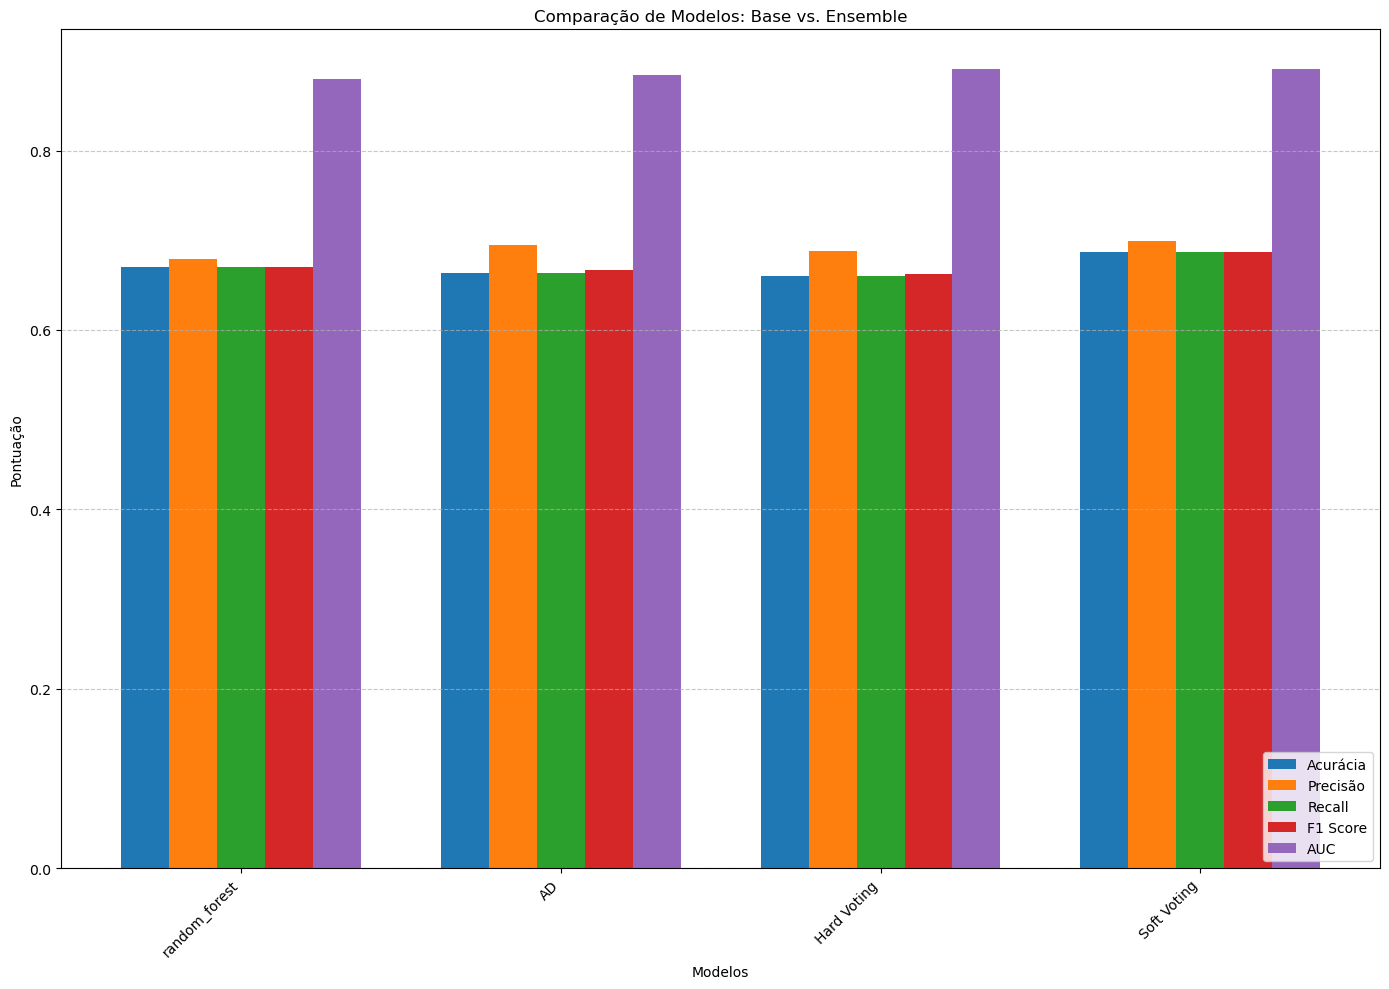

Melhor modelo: Soft Voting


In [ ]:
#VOTING ENSEMBLE  -------------------------------------------------------------------------------------------------------------------------------------
from sklearn.ensemble import  VotingClassifier

#ESTÁ A REALIZAR O RANDOM FOREST+ÁRVORE DE DECISÃO, PARA COLOCAR COM SUPPORT VECTOR MACHINE É SÓ TROCAR COM O QUE ESTÁ EM COMENTÁRIO
base_models = [
    ('random_forest', melhor_modelo_RF),
    ('AD', melhor_modelo_AD),       #('SVM', best_svm )
]

#IDENTIFICAR AS CLASSES ÚNICAS
classes = np.unique(y_train)
n_classes = len(classes)

#BINARIZE O Y_TEST PARA O CÁLCULO DE AUC 
y_test_bin = label_binarize(y_test, classes=classes)

#PARA ARMAZENAR OS RESULTADOS 
resultados = {
    'Modelo': [],
    'Acurácia': [],
    'Precisão': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': [] 
}

#AVALIAR CADA MODELO INDIVIDUAL 
for nome, modelo in base_models:
    #print(f"\nAvaliar modelo: {nome}")
    #TREINAR O MODELO
    modelo.fit(X_train, y_train)
    #FAZER PREVISÕES
    y_test_pred = modelo.predict(X_test)
    y_test_proba = modelo.predict_proba(X_test)

    #CALCULAR MÉTRICAS DE AVALIAÇÃO
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    #CALCULAR AUC
    auc_score = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr', average='macro')
    
    #ARMAZENAR OS RESULTADOS
    resultados['Modelo'].append(nome)
    resultados['Acurácia'].append(accuracy)
    resultados['Precisão'].append(precision)
    resultados['Recall'].append(recall)
    resultados['F1 Score'].append(f1)
    resultados['AUC'].append(auc_score)
    
    #print(f"Acurácia: {accuracy:.4f}, F1 Score: {f1:.4f}")

#HARD VOTING 
hard_voting = VotingClassifier(
    estimators=base_models,
    voting='hard',
    n_jobs=-1
)

#SOFT VOTING 
soft_voting = VotingClassifier(
    estimators=base_models,
    voting='soft',
    n_jobs=-1
)


#LISTAS DOS MODELOS DE VOTING PARA AVALIAR
voting_models = [
    ('Hard Voting', hard_voting),
    ('Soft Voting', soft_voting)
]

for nome, modelo in voting_models:
    #print(f"\nTreinando modelo: {nome}")
    
    #TREINAR O MODELO
    modelo.fit(X_train, y_train)
    
    #FAZER PREVISÕES
    y_test_pred = modelo.predict(X_test)
    
    if nome == 'Soft Voting':
        y_test_proba = modelo.predict_proba(X_test)
    else:
        probas = []
        for _, estimator in base_models:
            if hasattr(estimator, 'predict_proba'):
                probas.append(estimator.predict_proba(X_test))
        
        if probas:  
            y_test_proba = np.mean(probas, axis=0)
        else:
            y_test_proba = np.zeros((len(y_test), n_classes))
    
    #CALCULAR MÉTRICAS DE AVALIAÇÃO
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    #CALCULAR AUC
    try:
        auc_score = roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr', average='macro')
    except:
        auc_score = np.nan  
    
    #ARMAZENAR OS RESULTADOS
    resultados['Modelo'].append(nome)
    resultados['Acurácia'].append(accuracy)
    resultados['Precisão'].append(precision)
    resultados['Recall'].append(recall)
    resultados['F1 Score'].append(f1)
    resultados['AUC'].append(auc_score)
    
    #print(f"Acurácia: {accuracy:.4f}, F1 Score: {f1:.4f}")

#CRIAR DATAFRAME COM OS RESULTADOS
resultados_df = pd.DataFrame(resultados)
print("\n===== COMPARAÇÃO DE MODELOS =====")
print(resultados_df.sort_values('F1 Score', ascending=False))

#VISUALIZAÇÃO DOS RESULTADOS
plt.figure(figsize=(14, 10))
metrics = ['Acurácia', 'Precisão', 'Recall', 'F1 Score', 'AUC']
x = np.arange(len(resultados['Modelo']))
width = 0.15

for i, metric in enumerate(metrics):
    offset = width * (i - len(metrics)/2 + 0.5)
    plt.bar(x + offset, resultados[metric], width, label=metric)

plt.xlabel('Modelos')
plt.ylabel('Pontuação')
plt.title('Comparação de Modelos: Base vs. Ensemble')
plt.xticks(x, resultados['Modelo'], rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#ENCONTRAR O MELHOR MODELO COM BASE NO F1 SCORE 
melhor_idx = resultados_df['F1 Score'].idxmax()
melhor_modelo_nome = resultados_df.loc[melhor_idx, 'Modelo']
melhor_modelo = None

#DETERMINAR QUAL É O MELHOR MODELO 
for nome, modelo in base_models + voting_models:
    if nome == melhor_modelo_nome:
        melhor_modelo = modelo
        break
print(f"Melhor modelo: {melhor_modelo_nome}")
